<h1 style="text-align:center;"> LSTM for Stock Market Prediction</h1>
<h2 style="text-align:center;"> TESLA</h2>

<p style="font-size:18px;color:gray;"> <strong>Step 1:</strong> For this Predictive model we will utilize some modules that are necessary to obtain, create and visualize this predictive model such as <span class="py-modules">sqlalchemy</span>, <span class="py-modules">NumPy</span>, <span class="py-modules">Pandas</span>, <span class="py-modules">SciKitlearn</span>, <span class="py-modules">MatPlotLib</span>, and <span class="py-modules">Keras</span>.</p>

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime as dt
import requests
from sqlalchemy import create_engine
from config import password

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 2:</strong> </p> <p style="font-size:18px;color:gray;line-height:normal;"> Now, we start building our model by first defining the dataset that the model will train on. We're using datasets from NASDAQ provided by <a href="https://finance.yahoo.com/">https://finance.yahoo.com/</a>. For this example were using <span style="color:blue;">Tesla TSL</span> historical data.

 <p style="font-size:18px;color:gray;"> After pulling the data from our SQL database we read it using the the csv built-in function included in the Pandas library.</p>

In [2]:
# Connecting to Database
connection_string = f"ofygklqv:{password}@batyr.db.elephantsql.com:5432/ofygklqv"
engine = create_engine(f'postgresql://{connection_string}', pool_size=2, pool_recycle=1200, connect_args={'connect_timeout': 10},
client_encoding="utf8", pool_pre_ping=True)

In [3]:
ticker = "TSLA"
df = pd.read_sql_query('select * from ticker', con=engine)
id = df[df['symbol']==ticker]['stock_id'].values[0] # returning ID for the specified ticker(symbol)
df = pd.read_sql_query(f'select * from stock WHERE stock_id = {id}', con=engine)
print(df.shape)
df["date"]=pd.to_datetime(df.date,format="%Y-%m-%d")
df.index = df['date']
df = df[["close"]]

(1258, 7)


#### Sort date and close
<p style="font-size:14px;color:gray;"> Since the dates and values are in descending order we need to reverse the dataframe</p>

In [4]:
df = df.iloc[::-1]
df

,close
date,
2016-07-06,42.888000
2016-07-07,43.188000
2016-07-08,43.355999
2016-07-11,44.956001
2016-07-12,44.930000
...,...
2021-06-28,688.719971
2021-06-29,680.760010
2021-06-30,679.700012


<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 3: Plotting the close prices</strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">We'll plot the close prices using "Close" values as our dependent variable and Date as our independent variable(this is time scale).</p>

Text(0, 0.5, 'Close Price USD')

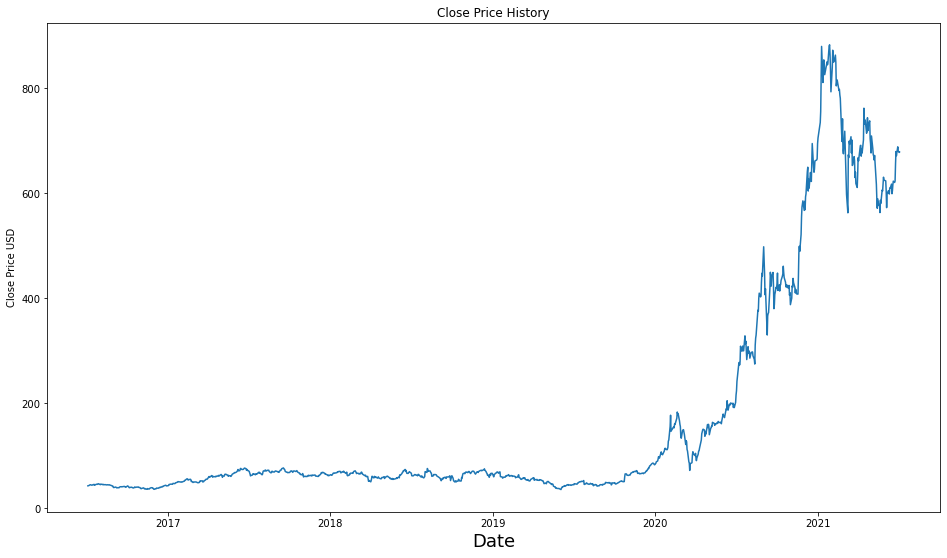

In [5]:
plt.figure(figsize=(16,9))
plt.title("Close Price History")
plt.plot(df['close'])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD")

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 4: Splitting the data into Training/Test sets </strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">Once the data has been cleaned and filtered, we need to split the data into train and test data, since our model doesn't utilize more than one variable, we can't use train_test_split found in <span class="py-modules">sklearn</span> libray. We will use a 80-20 ratio for the splitting process.</p>

In [6]:
# Create New DataFrame with close values
data = df
# Convert Dataframe to Numpy array
dataset = data.values

In [7]:
training_data_len = math.ceil(len(dataset) * 0.80)
training_data_len

1007

In [8]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00837252],
       [0.00872659],
       [0.00892486],
       ...,
       [0.75995401],
       [0.75785317],
       [0.75900984]])

In [9]:
# Create training Dataset
#create the scaled Training Data Set
train_data = scaled_data[0:training_data_len,:]
#split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=60:
    print(x_train)
    print(y_train)
    print()

[array([0.00837252, 0.00872659, 0.00892486, 0.01081322, 0.01078254,
       0.01028212, 0.01004608, 0.00977935, 0.01116021, 0.01092652,
       0.01165827, 0.00980295, 0.01022075, 0.01204774, 0.01192972,
       0.01168895, 0.01218937, 0.01317603, 0.01204774, 0.01138445,
       0.01105163, 0.01218937, 0.01205246, 0.01113896, 0.01182822,
       0.01101858, 0.01084391, 0.01100914, 0.01100442, 0.01053705,
       0.01044971, 0.01051345, 0.01086515, 0.01037654, 0.01082738,
       0.01030336, 0.00991153, 0.00968257, 0.00855191, 0.00764078,
       0.00779893, 0.00514578, 0.00444001, 0.00563204, 0.00536766,
       0.00434087, 0.0036587 , 0.00456275, 0.00403165, 0.00411663,
       0.00506317, 0.00623867, 0.00646056, 0.00605928, 0.00619618,
       0.0064818 , 0.00672257, 0.00708607, 0.00633545, 0.00644403])]
[0.0051292588741876505]



In [10]:
# convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
samples,time_steps = x_train.shape
print(samples,time_steps)

947 60


In [12]:
# Reshaping the data
x_train = np.reshape((x_train),(samples,time_steps,1))
x_train.shape

(947, 60, 1)

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 5: LSTM build</strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">At this point our dataset is clean and scaled, this allows us to build the LSTM model that is going to process and predict the values. The 2 main parameters used are  optimizer=<span style="color:green;">'adam'</span> and loss=<span style="color:green;">'mean_squared_error'</span>; found in the <span class="py-modules">LSTM</span> module</p>

In [13]:
# Building the LSTM Model
model = Sequential()
# Creating Layers
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps,1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [14]:
# Compiling the model
# Loss function is used to measure how well the model did on training.
model.compile(optimizer='adam', loss='mean_squared_error')

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 6: Training our Model
    </strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">It's time to train our model, this requires a x_train and y_train datasets, among other parameters. To see the meaning of these parameters please visit tensorflow's official website <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM">https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM</a> </p>

In [15]:
#training the Model
# Batch size is the total number of training examples present in a single batch
# Epoch is the iterations when an entire dataset is passed forward and backward through a neural network
model.fit(x_train, y_train, batch_size=1, epochs=2,verbose=5)

Epoch 1/2
Epoch 2/2


In [16]:
# creating the Testing dataset 
# Array that contained scaled values test_data = scaled_data[training_data_len - 60:through the end, all columns]

test_data = scaled_data[training_data_len-60: , :]
# Creating testing datasets 
x_test = []
y_test = dataset[training_data_len: , :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])
  


In [17]:
# Converting data to a numpy Array
x_test = np.array(x_test)


In [18]:
# Reshaping the data, because LST model is expecting a 3 dimensional array
# x_test.shape[0] represents the number of Rows, 
#  x_test.shape[1] represents the number of time steps
# 3rd element in the dimensional array (1) represents the close price
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 7: Make/Perform the Predictions
    </strong> </p> <p style="font-size:18px;color:gray;line-height:normal;">To make our predictions we need make use of our x_test dataset, it's important to mention that this numpy array must be a 3 dimensional array(see description in cell above)</p>

In [19]:
# Get the models predicted price values
# This step "unscale" the values

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 8: Test Model on test data
    </strong> </p> <p style="font-size:18px;color:gray;line-height:normal;"></p>

In [20]:
# Evaluating our model, Getting the root mean error (RMSE), Model accuracy 
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

23.546693596706923

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 9: Plotting trained, tested and predicted datasets.
    </strong> </p> <p style="font-size:18px;color:gray;line-height:normal;"></p>

In [21]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions

C:\Users\admin\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


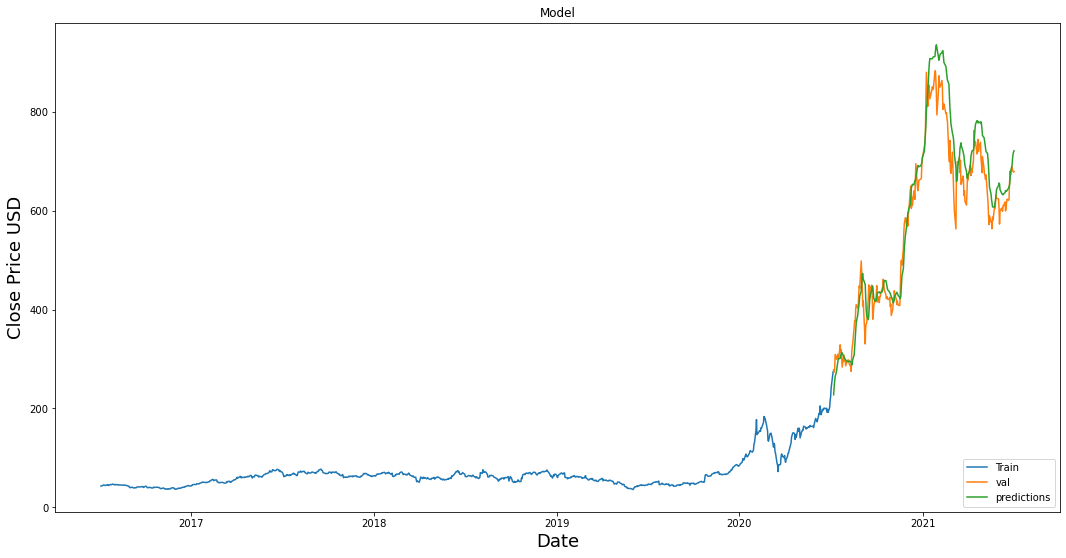

In [22]:
# Visualize the models data
plt.figure(figsize=(18,9))
plt.title('Model')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD", fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close','predictions']])
plt.legend(['Train','val','predictions'], loc='lower right')
plt.show()

<p style="font-size:18px;color:gray;"> <strong style="line-height: 0px;">Step 10: Saving Model(h5).
    </strong> </p> <p style="font-size:18px;color:gray;line-height:normal;"></p>

In [23]:
# Using .h5 format
model.save("tesla_model.h5")